In [ ]:
import cassio
import os
#Connect to Astra DB

ASTRA_DB_APPLICATION_TOKEN = os.environ.get("ASTRA_DB_APPLICATION_TOKEN")

ASTRA_DB_ID=os.environ.get("ASTRA_DB_ID")

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [45]:
# Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

# Docs to Index

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://liliansweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://liliansweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load Url

docs= [WebBaseLoader(url).load() for url in urls]
docs_list =[item for sublist in docs for item in sublist]
text_splitter= RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
docs_split = text_splitter.split_documents(docs_list)

In [46]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-V2")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [47]:
from langchain.vectorstores.cassandra import Cassandra

astra_vector_store = Cassandra(
    embedding=embedding,
    session=None,
    keyspace=None,
    table_name="qa_mini_demo"
)

In [48]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

astra_vector_store.add_documents(docs_split)

print("Inserted %i headlines." % len(docs_split))
astra_vector_index = VectorStoreIndexWrapper(vectorstore = astra_vector_store)

Inserted 33 headlines.


In [77]:
retriever = astra_vector_store.as_retriever()

retriever.invoke("What is an agent?")

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Planning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X\'s plan today in broad strokes: 1)\nRelationships between agents and observations of one agent by another are all taken into consideration for planning and reacting.\nEnvironment info

In [50]:
# Langgraph application

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [51]:
# Data Model
class RouteQuery(BaseModel):
  """Route a user query to the most relevant datasource."""

  datasource : Literal["vectorstore","wiki_search"] = Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore."
  )

In [52]:
from langchain_groq import ChatGroq
from google.colab import userdata
groq_api_key = userdata.get("groq_api_key")

In [53]:
llm =ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-70b-versatile")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ac053484100>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ac053484dc0>, model_name='llama-3.1-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [54]:
llm.invoke("Hi")

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.092, 'prompt_time': 0.011054249, 'queue_time': 0.004701700000000001, 'total_time': 0.103054249}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'stop', 'logprobs': None}, id='run-7d182f9d-e41e-4468-b9fc-a88adb1ae750-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [55]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [56]:
#Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for queestion on these topics. Otherwise, use wiki-search."""

router_prompt =ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","{question}")
    ]
)

question_router = router_prompt | structured_llm_router

In [57]:
print(question_router.invoke(
    {
        "question":"Who is Sharukh khan?"
    }
))

datasource='wiki_search'


In [58]:
print(question_router.invoke(
    {
        "question":"What is agent?"
    }
))

datasource='vectorstore'


In [60]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)
#

In [61]:
wiki.run("Tell me about Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Refe'

In [62]:
#Ai-Agents Application using Langgraph

from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """
  Represents the state of the graph.

  Attributes:
    question: question
    generation: LLM generation
    documents: List of documents
  """
  question: str
  generation: str
  documents: List[str]

In [63]:
from langchain.schema import Document

def retireve(state):
  """
  Retrieve documents

  Args:
    state(dict): The current graph state

  Returns:
    state(dict): New key added to state, documents that contains retrieved documents
  """

  print("---RETRIEVE---")
  question  = state["question"]

  #Retrieval
  documents = retriever.invoke(question)
  return {"documents":documents,"question":question}

In [106]:
def wiki_search(state):
  """
  wikipedia Search

  Args:
    state(dict): The current graph state

  Returns:
    state(dict): Updates documents key with appended web results
  """
  print("---WIKI SEARCH---")
  question = state["question"]

  print(question)

  #Wiki Search
  docs = wiki.run(
      question
  )

  wiki_results= docs
  wiki_results= Document(page_content = wiki_results)

  return {"documents": wiki_results, "question":question}

In [107]:
def route_question(state):
  """
  Route question to wiki search or RAG

  Args:
    state(dict): The current graph state

  Returns:
    state(dict): Updates documents key with appended web results
  """
  print("---ROUTE QUESTION---")
  question = state["question"]
  source = question_router.invoke(
      {
          "question":question
      }
  )

  if source.datasource == "wiki_search":
    print("--ROUTE QUESTION TO WIKI SEARCH--")
    return "wiki_search"
  else:
    print("--ROUTE QUESTION TO RAG--")
    return "vectorstore"

In [108]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

#Define Nodes
workflow.add_node("wiki_search",wiki_search)
workflow.add_node("retrieve", retireve)

#Build The graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve"
    },
)
workflow.add_edge("retrieve",END)
workflow.add_edge("wiki_search",END)

#Compile the graph

app =workflow.compile()

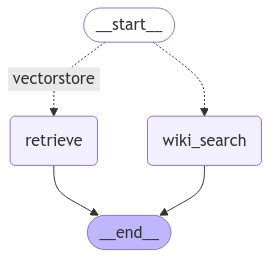

In [109]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [116]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---


--ROUTE QUESTION TO RAG--
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Planning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X\'s plan today in broad strokes: 1)\nRelationships between agents and observations of one agent by another are all

In [121]:
from pprint import pprint

# Run
inputs = {
    "question": "Who are Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
page_content = value['documents'].dict()['page_content']
summary = page_content.split('\n')[1].replace('Summary: ', '')  # Remove 'Summary: '
print(summary)

---ROUTE QUESTION---
--ROUTE QUESTION TO WIKI SEARCH--
---WIKI SEARCH---
Who are Avengers
"Node 'wiki_search':"
'\n---\n'
The Young Avengers are the names of two superhero teams appearing in American comic books published by Marvel Comics. Created by Allan Heinberg and Jim Cheung, the first 
